# Regularization

From the previous lectures, we know that more features do not always lead to better performance. Sometimes, adding more features can lead to overfitting.

In this notebook, we will introduce another way to prevent overfitting: **regularization**. Regularization is a technique to prevent overfitting by penalizing complex models.


## Ridge Regression

Assume a centered linear regression model where the data have been pre-processed so that the mean of each feature (and the target) is zero. This means we don’t need a separate intercept term, simplifying the model to:

$$f(x_i) = \sum_{j=1}^p x_{ij} \beta_j$$

### Constrained Formulation

Ridge regression can be understood through a constrained optimization approach. We seek to minimize the residual sum of squares, subject to a constraint that limits the magnitude of the coefficients:

$$
\begin{align*}
&\min_{\beta}  \sum_{i=1}^N \left( \sum_{j=1}^p x_{ij} \beta_j - y_i \right)^2 \
&\text{subject to} \quad \sum_{j=1}^p \beta_j^2 \leq t
\end{align*}
$$

This formulation restricts the coefficients to lie within a $p$-dimensional ball, effectively controlling the model’s complexity by preventing the coefficients from becoming too large.

- When $t = 0$, all coefficients are zero, and the model always predicts 0. 
- When $t$ is very large, the constraint effectively disappears, and the model is the same as the unregularized linear regression model.


### Penalty Formulation

An equivalent way to express ridge regression is through a penalized objective function, where we minimize the residual sum of squares and include a penalty on the coefficients:

$$
\min_{\beta}  \sum_{i=1}^N \left( \sum_{j=1}^p x_{ij} \beta_j - y_i \right)^2 + \alpha \sum_{j=1}^p \beta_j^2
$$

Here, $\alpha$ is a regularization parameter that controls the strength of the penalty. A higher $\alpha$ discourages large coefficient values, shrinking them closer to zero.


- When $\alpha = 0$, we revert to the original least-squares linear regression model without regularization.
- When $\alpha$ is very large, the penalty forces all coefficients \beta_j close to zero, effectively reducing the model to a constant prediction.

The constrained and penalized formulations are equivalent due to the Lagrange multiplier principle, with a one-to-one correspondence between $\alpha$ and t, allowing us to interpret ridge regression as finding an optimal balance between fit and complexity.

### Ridge Regression Solution

The ridge regression problem can be written as:

$$
\min_{\beta} \|X \beta - y\|_2^2 + \lambda \|\beta\|_2^2
$$

The optimal solution is:

$$
\hat{\beta}_{\text ridge} = (X^T X + \lambda I)^{-1} X^T y
$$

where $I$ is the identity matrix.
    



## The Lasso

The lasso is another way to regularize the linear regression model. The optimization problem is:

$$
\min_{\beta}  \sum_{i=1}^N (\sum_{j=1}^p x_{ij} \beta_j - y_i)^2 + \alpha \sum_{j=1}^p |\beta_j|
$$

where $\alpha$ is the regularization strength.

We can also write the problem as a constrained optimization problem:

$$
\begin{align*}
&\min_{\beta}  \sum_{i=1}^N (\sum_{j=1}^p x_{ij} \beta_j - y_i)^2 \\
&\text{subject to} \sum_{j=1}^p |\beta_j| \leq t
\end{align*}
$$

Compared with ridge regression, the lasso tends to produce sparse solutions: it encourages the coefficients to be exactly 0. 
This is useful in practice because it can help us select a subset of the features.

## Intercept Term

For all the previous discussion, we assuming X and y are centered, thus there is no need for an intercept term. If the data is not centered, we can add an intercept term to the model

$$
\min_{\beta}  \sum_{i=1}^N (\beta_0 + \sum_{j=1}^p x_{ij} \beta_j - y_i)^2 + \alpha \sum_{j=1}^p \beta_j^2
$$

Notice that the intercept term $\beta_0$ is not penalized. 

- If $\beta_0$ is penalized, then taking $\alpha$ to be very large will force $\beta_0, \beta_1, \ldots, \beta_p$ to be 0, and the model will be a trivial model (i.e., $f(x) = 0$).

- If $\beta_0$ is not penalized, then $\beta_0$ will be the mean of the target variable $y$. To verify this, notice that setting the derivative of the loss function with respect to $\beta_0$ to zero gives the same equation in linear regression (as the intercept term is not penalized).


There is an optional argument `fit_intercept` (True by default) in the `Ridge`, `Lasso` and `LinearRegression` classes in `sklearn` to control whether to include the intercept term in the model.

## Example
We will use the [diabetes dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html) from sklearn to demonstrate the effect of regularization.

Features: 

- age age in years
- sex
- bmi body mass index
- bp average blood pressure
- s1 tc, total serum cholesterol
- s2 ldl, low-density lipoproteins
- s3 hdl, high-density lipoproteins
- s4 tch, total cholesterol / HDL
- s5 ltg, possibly log of serum triglycerides level
- s6 glu, blood sugar level

Target: 

a quantitative measure of disease progression one year after baseline

Let's first visualize the data using the heatmap of the correlation matrix and the pairwise scatter plot.

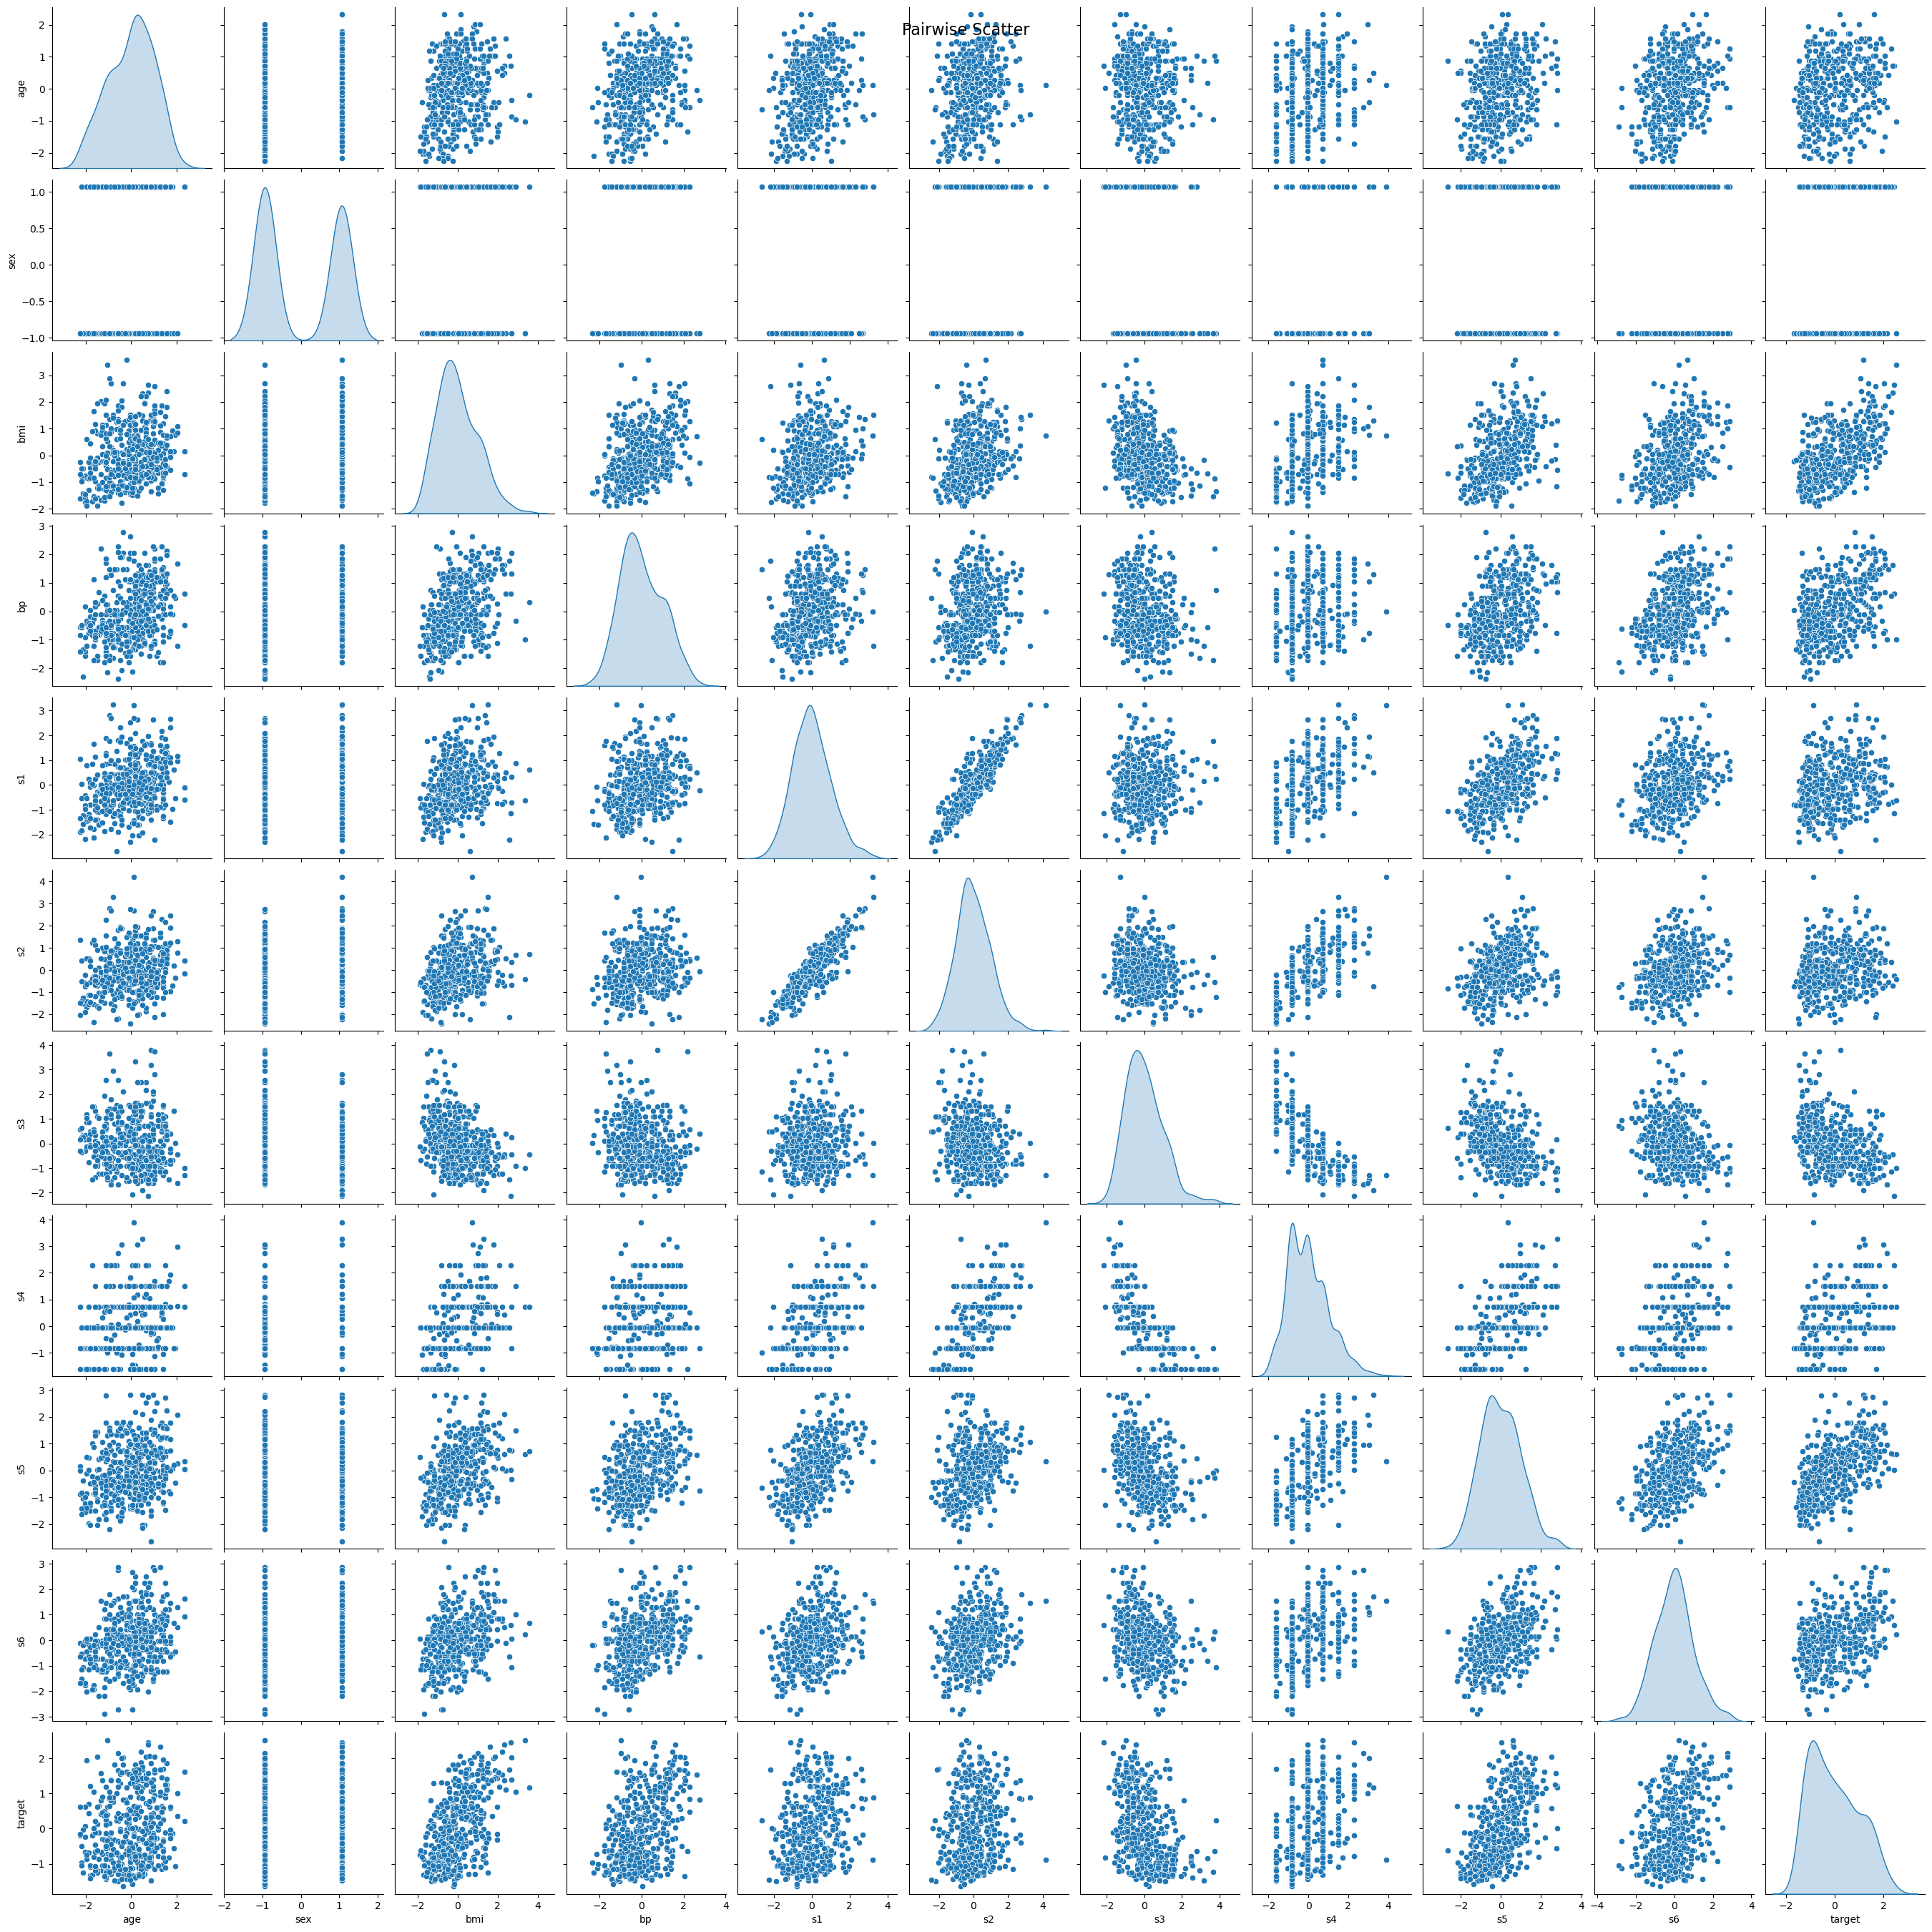

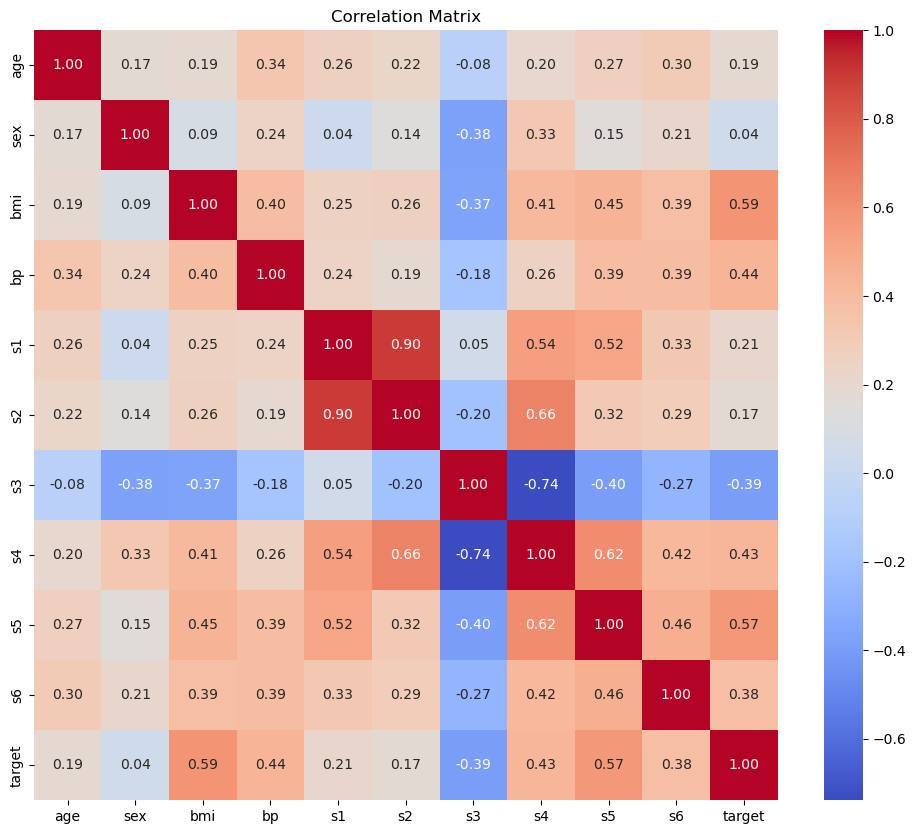

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

# Load the diabetes dataset as a dataframe
# X is already standardized 
data = load_diabetes(as_frame=True, scaled=False)
X = data.data  # Feature data as DataFrame
y = data.target  # Target data as Series


# Combine X and y into a single DataFrame for analysis
df = pd.concat([X, y.rename('target')], axis=1)

# Standardize the data
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

X = df.drop('target', axis=1)
y = df['target']


# Pairwise scatter plot
# sample 100 data points to make the plot clearer
sns.pairplot(df, diag_kind='kde')
plt.suptitle('Pairwise Scatter', size=16)
plt.show()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

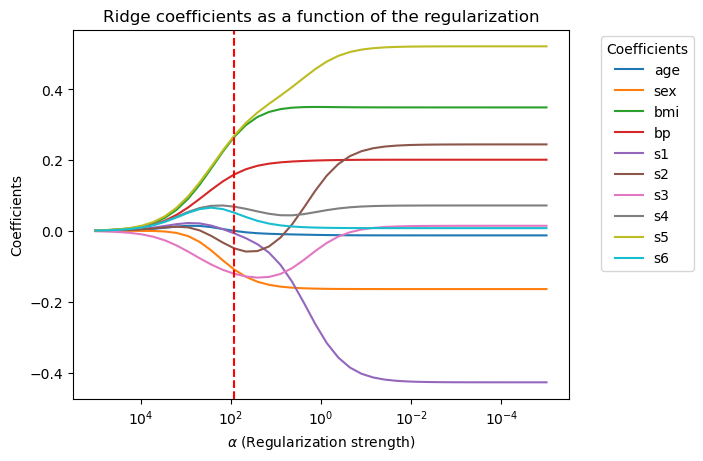

coefficient at min_test_error_alpha: [ 9.37153097e-05 -1.09163668e-01  2.65707502e-01  1.59578512e-01
 -6.93877963e-03 -4.93132970e-02 -1.21053700e-01  6.85101498e-02
  2.69306909e-01  5.15067721e-02]


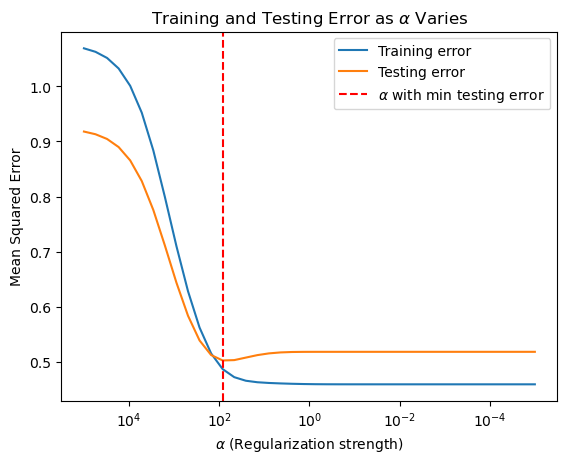

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Range of alpha values for regularization, from 10^5 to 10^-5
alphas = np.logspace(5, -5, 40)

# Array to store coefficients
coefficients = np.zeros((len(alphas), X_train.shape[1]))

# Lists to store training and testing errors
train_mse = []
test_mse = []

# Perform Ridge Regression with different values of alpha
for index, alpha in enumerate(alphas):

    # Fit Ridge Regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    
    # Calculate training and testing errors
    y_train_pred = ridge.predict(X_train)
    y_test_pred = ridge.predict(X_test)

    train_mse.append(mean_squared_error(y_train, y_train_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))
    
    # Store coefficients
    coefficients[index, :] = ridge.coef_

# Find the alpha value that minimizes the testing error
min_test_error_alpha = alphas[np.argmin(test_mse)]

# Plotting coefficients as a function of alpha
plt.figure()
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i], label=X.columns[i])
plt.axvline(min_test_error_alpha, color='red', linestyle='--')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.xlabel(r'$\alpha$ (Regularization strength)')
plt.ylabel('Coefficients')
plt.title('Ridge coefficients as a function of the regularization')
plt.legend(title="Coefficients", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

best_coef = coefficients[np.argmin(test_mse)]
print(f'coefficient at min_test_error_alpha: {best_coef}')

# Plotting training and testing error as a function of alpha
plt.figure()
plt.plot(alphas, train_mse, label='Training error')
plt.plot(alphas, test_mse, label='Testing error')
plt.axvline(min_test_error_alpha, color='red', linestyle='--', label=r'$\alpha$ with min testing error')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.xlabel(r'$\alpha$ (Regularization strength)')
plt.ylabel('Mean Squared Error')
plt.title(r'Training and Testing Error as $\alpha$ Varies')
plt.legend()
plt.show()


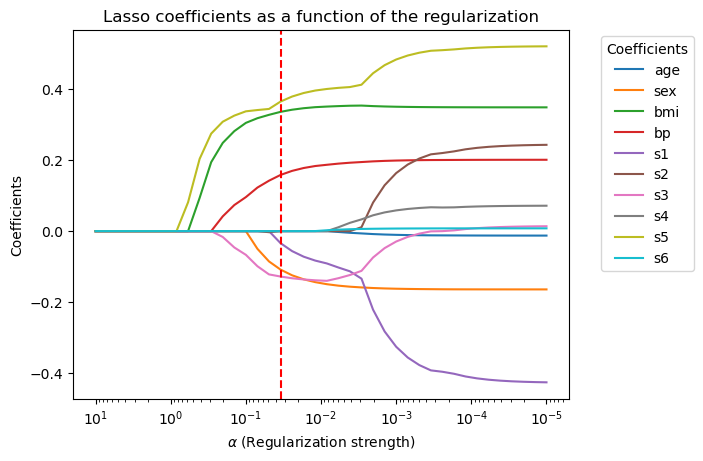

coefficient at min_test_error_alpha: [-0.         -0.10841615  0.33611424  0.15834881 -0.03398622 -0.
 -0.12795557  0.          0.36510404  0.        ]


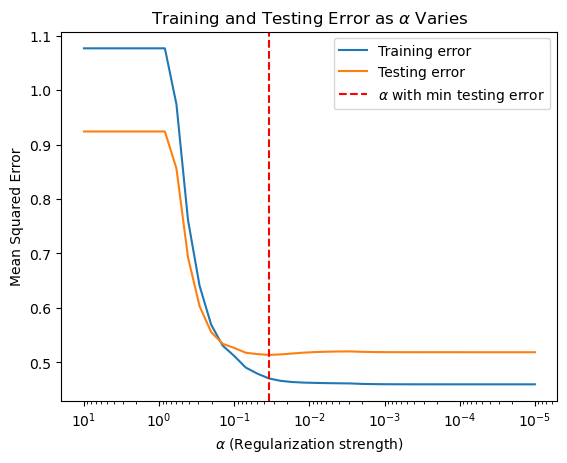

In [4]:
from sklearn.linear_model import Lasso

# Range of alpha values for regularization, from 10^1 to 10^-5
alphas = np.logspace(1, -5, 40)

# Array to store coefficients
coefficients = np.zeros((len(alphas), X_train.shape[1]))

# Lists to store training and testing errors
train_errors = []
test_errors = []


# Perform Lasso Regression with different values of alpha
for index, alpha in enumerate(alphas):

    # Fit Lasso Regression
    ridge = Lasso(alpha=alpha)
    ridge.fit(X_train, y_train)
    
    # Calculate training and testing errors
    y_train_pred = ridge.predict(X_train)
    y_test_pred = ridge.predict(X_test)
    
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))
    
    # Store coefficients
    coefficients[index, :] = ridge.coef_

# Find the alpha value that minimizes the testing error
min_test_error_alpha = alphas[np.argmin(test_errors)]

# Plotting coefficients as a function of alpha
plt.figure()
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i], label=X.columns[i])
plt.axvline(min_test_error_alpha, color='red', linestyle='--')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.xlabel(r'$\alpha$ (Regularization strength)')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients as a function of the regularization')
plt.legend(title="Coefficients", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

best_coef = coefficients[np.argmin(test_errors)]
print(f'coefficient at min_test_error_alpha: {best_coef}')

# Plotting training and testing error as a function of alpha
plt.figure()
plt.plot(alphas, train_errors, label='Training error')
plt.plot(alphas, test_errors, label='Testing error')
plt.axvline(min_test_error_alpha, color='red', linestyle='--', label=r'$\alpha$ with min testing error')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.xlabel(r'$\alpha$ (Regularization strength)')
plt.ylabel('Mean Squared Error')
plt.title(r'Training and Testing Error as $\alpha$ Varies')
plt.legend()
plt.show()



In ridge regression, as the regularization strength gradually decreases, the coefficients smoothly transition from 0 toward the values of the least squares solution, with all coefficients increasing together.

In contrast, for Lasso, as regularization weakens, many coefficients remain exactly at 0 until they abruptly increase to nonzero values, creating a “piecewise” effect. This behavior exemplifies lasso’s ability to promote sparsity by setting many coefficients precisely to zero rather than merely shrinking them.

## Some takeaways:

- Both Lasso and Ridge regression are used to prevent overfitting in linear models.

- Both require the feature to be of the same scale.

- Ridge regression has a closed-form solution, while Lasso does not.

- Lasso tends to produce sparse solutions, that is, it encourages the coefficients to be exactly 0.

- The choice of $\alpha$ is important. It can be chosen by cross-validation.

## Why does the Lasso prefer sparse solutions?

Consider the contrained optimization problem of the lasso and the ridge regression. We can visualize the constraints in 2 dimensions.

The elliptical contours are contours of the loss function of linear regression (without regularization). $\hat{\beta}$ is the optimal solution for linear regression.

The diamond and the circle region represent the constraints. For the ridge regression, the coefficients are constrained in a ball, while for the lasso, the coefficients are constrained in a diamond shape.


The optimal solution occurs where the loss function contours are tangent to these constraint boundaries. For ridge regression, this point typically lies on the boundary of the circle, yielding non-zero coefficients. In contrast, for lasso, the solution often occurs at one of the diamond’s corners, where some coefficients are zero. (These corners represent the farthest points from the origin within the diamond.)


![Figure Description](https://images.datacamp.com/image/upload/v1648205672/image18_a3zz7y.png)

[Souce](https://online.stat.psu.edu/stat508/book/export/html/749)